In [2]:
!pip install folium
!pip install geopy
!pip install tensorflow
!pip install keras
!pip install sparkdl

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, decode, date_format, unix_timestamp, lag, when
from pyspark.sql.types import StructType, StructField, StringType, TimestampType
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.window import Window
import pandas as pd
import folium
from geopy.geocoders import Nominatim
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest as SkIsolationForest
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from pyspark.sql.functions import col, from_json

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, decode, date_format
from pyspark.sql.types import StructType, StructField, StringType, TimestampType

# Create a SparkSession
spark = SparkSession.builder \
    .appName("first_app") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.0") \
    .getOrCreate()

# Read data from Kafka
df = spark \
    .read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "44.201.154.178:9092") \
    .option("subscribe", "health_events") \
    .option("startingOffsets", "earliest") \
    .load()

In [ ]:
# Decode the value column
df = df.withColumn("decoded_value", decode(col("value"), "UTF-8"))

# Parse JSON content into separate columns
schema = StructType([
    StructField("EventType", StringType(), True),
    StructField("Timestamp", TimestampType(), True),
    StructField("Location", StringType(), True),
    StructField("Severity", StringType(), True),
    StructField("Details", StringType(), True)
])

df = df.withColumn("decoded_json", from_json(col("decoded_value"), schema)) \
       .select("decoded_json.*")

# Format the month from number to name (assuming timestamp is already in the dataframe)
df = df.withColumn("month_name", date_format(col("Timestamp"), "MMMM"))

df.show(truncate=False)

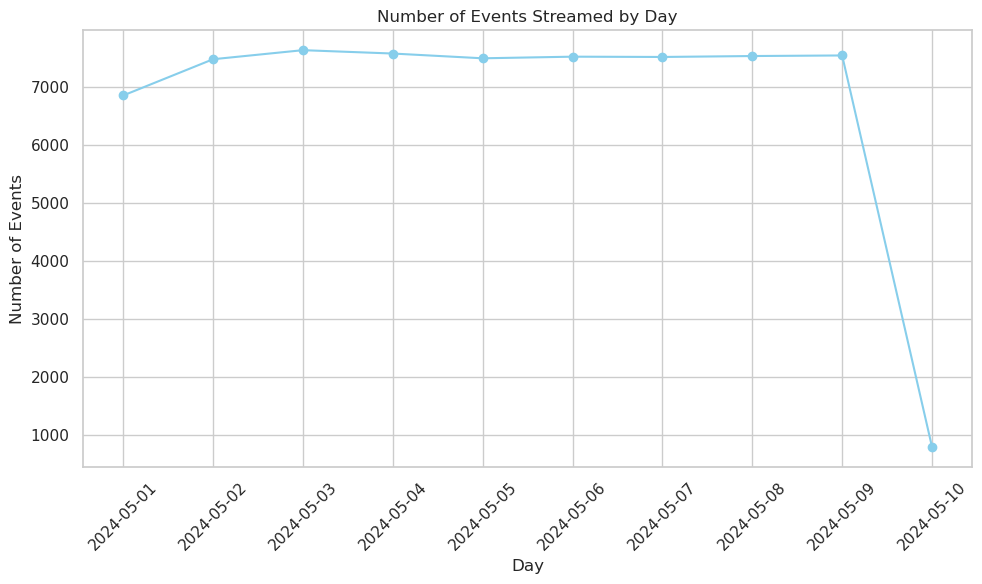

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, date_format, window

# Convert Spark DataFrame to Pandas DataFrame for easier plotting
df_pandas = df.withColumn("day", date_format(col("Timestamp"), "yyyy-MM-dd")) \
    .groupBy("day").count() \
    .orderBy("day") \
    .toPandas()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df_pandas['day'], df_pandas['count'], marker='o', color='skyblue', linestyle='-')
plt.title('Number of Events Streamed by Day')
plt.xlabel('Day')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [19]:
from pyspark.sql.functions import col, from_json
# export spark dataframe to pandas dataframe
df_with_json = df.withColumn("json_data", from_json(col("decoded_value"), schema))

# Expanding the JSON data into separate columns
df_expanded = df_with_json.select(
    "decoded_value",
    col("json_data.EventType").alias("EventType"),
    col("json_data.Timestamp").alias("Timestamp"),
    col("json_data.Location").alias("Location"),
    col("json_data.Severity").alias("Severity"),
    col("json_data.Details").alias("Details")
)

df_expanded.show(truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+-------------------+-----------+--------+------------------------------------------------+
|decoded_value                                                                                                                                                                             |EventType            |Timestamp          |Location   |Severity|Details                                         |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+-------------------+-----------+--------+------------------------------------------------+
|{"EventType": "vaccination", "Timestamp": "2024-05-01 02:14:49", "Location": "London", "Severity

In [20]:
# Decode the value column
df = df.withColumn("decoded_value", decode(col("value"), "UTF-8"))

# Parse JSON content into separate columns
schema = StructType([
    StructField("EventType", StringType(), True),
    StructField("Timestamp", TimestampType(), True),
    StructField("Location", StringType(), True),
    StructField("Severity", StringType(), True),
    StructField("Details", StringType(), True)
])

df = df.withColumn("decoded_json", from_json(col("decoded_value"), schema)) \
       .select("decoded_json.*")

# Format the month from number to name (assuming timestamp is already in the dataframe)
df = df.withColumn("month_name", date_format(col("Timestamp"), "MMMM"))



In [21]:
# Show the DataFrame
df.show(truncate=False)

+---------------------+-------------------+-----------+--------+------------------------------------------------+----------+
|EventType            |Timestamp          |Location   |Severity|Details                                         |month_name|
+---------------------+-------------------+-----------+--------+------------------------------------------------+----------+
|vaccination          |2024-05-01 02:14:49|London     |low     |This is a simulated vaccination event.          |May       |
|emergency_incident   |2024-05-01 02:14:56|Paris      |high    |This is a simulated emergency_incident event.   |May       |
|emergency_incident   |2024-05-01 02:15:13|Boston     |high    |This is a simulated emergency_incident event.   |May       |
|health_mention       |2024-05-01 02:15:18|Berlin     |low     |This is a simulated health_mention event.       |May       |
|health_mention       |2024-05-01 02:15:35|Paris      |low     |This is a simulated health_mention event.       |May       |


In [7]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import RandomForestClassifier

# Assuming you have categorical columns: "EventType", "Location", "Severity"
categorical_columns = ["EventType", "Location", "Severity"]

# Define StringIndexer for each categorical column
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep") for column in categorical_columns]


In [8]:
from pyspark.sql.functions import unix_timestamp
from pyspark.ml.feature import VectorAssembler

# Convert the "Timestamp" column to a numeric representation
df = df.withColumn("Timestamp_numeric", unix_timestamp("Timestamp"))

# Define features (excluding "Details" column)
feature_columns = ["EventType", "Timestamp_numeric", "Location", "Severity"]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=[column+"_index" for column in ["EventType", "Location", "Severity"]] + ["Timestamp_numeric"], outputCol="features")

# Define Random Forest classifier
rf = RandomForestClassifier(labelCol="EventType_index", featuresCol="features", numTrees=10)

# Create pipeline (dropping the "Details" column)
pipeline = Pipeline(stages=indexers + [assembler, rf])

# Split the data into training and testing sets
(trainingData, testData) = df.randomSplit([0.8, 0.2], seed=42)

# Train the model
model = pipeline.fit(trainingData)

# Make predictions
predictions = model.transform(testData)


In [10]:
# Evaluate the model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="EventType_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [11]:
predictions.select("probability", "prediction", "features").show(truncate= False) 

+-----------------------------+----------+---------------------------+
|probability                  |prediction|features                   |
+-----------------------------+----------+---------------------------+
|[1.0,0.0,0.0,0.0,0.0,0.0,0.0]|0.0       |[0.0,4.0,2.0,1.714529768E9]|
|[1.0,0.0,0.0,0.0,0.0,0.0,0.0]|0.0       |[0.0,4.0,2.0,1.714530162E9]|
|[1.0,0.0,0.0,0.0,0.0,0.0,0.0]|0.0       |[0.0,1.0,2.0,1.714530472E9]|
|[1.0,0.0,0.0,0.0,0.0,0.0,0.0]|0.0       |[0.0,3.0,2.0,1.714530898E9]|
|[1.0,0.0,0.0,0.0,0.0,0.0,0.0]|0.0       |[0.0,0.0,2.0,1.71453156E9] |
|[1.0,0.0,0.0,0.0,0.0,0.0,0.0]|0.0       |[0.0,5.0,2.0,1.714531816E9]|
|[1.0,0.0,0.0,0.0,0.0,0.0,0.0]|0.0       |[0.0,0.0,2.0,1.714532498E9]|
|[1.0,0.0,0.0,0.0,0.0,0.0,0.0]|0.0       |[0.0,4.0,2.0,1.714532661E9]|
|[1.0,0.0,0.0,0.0,0.0,0.0,0.0]|0.0       |[0.0,1.0,2.0,1.71453319E9] |
|[1.0,0.0,0.0,0.0,0.0,0.0,0.0]|0.0       |[0.0,1.0,2.0,1.714533227E9]|
|[1.0,0.0,0.0,0.0,0.0,0.0,0.0]|0.0       |[0.0,2.0,2.0,1.714533371E9]|
|[1.0,

In [12]:
# Calculate the change in severity level for each event over time
windowSpec = Window.partitionBy("Location").orderBy("Timestamp")
df = df.withColumn("prev_severity", lag("Severity", 1).over(windowSpec))
df = df.withColumn("severity_change", when(col("Severity") == "high", 2)
                                      .when((col("Severity") == "medium") & (col("prev_severity") == "low"), 2)
                                      .when((col("Severity") == "medium") & (col("prev_severity") == "high"), 1)
                                      .when((col("Severity") == "medium") & (col("prev_severity") == "medium"), 0)
                                      .when((col("Severity") == "low") & (col("prev_severity") == "medium"), 1)
                                      .otherwise(0))

# Calculate the frequency of events
event_counts = df.groupBy("Location").count()

# Define thresholds for severity change and event frequency
severity_change_threshold = 1  # Define based on your criteria
event_frequency_threshold = 5  # Define based on your criteria

# Label events as anomalies
df = df.join(event_counts, "Location", "left")
df = df.withColumn("is_anomaly", when((col("severity_change") >= severity_change_threshold) & (col("count") >= event_frequency_threshold), 1)
                                   .otherwise(0))

# Drop intermediate columns
df = df.drop("prev_severity", "severity_change", "count")

# Show the DataFrame
df.show()


+--------+--------------------+-------------------+--------+--------------------+----------+-----------------+----------+
|Location|           EventType|          Timestamp|Severity|             Details|month_name|Timestamp_numeric|is_anomaly|
+--------+--------------------+-------------------+--------+--------------------+----------+-----------------+----------+
|  Berlin|      health_mention|2024-05-01 02:15:18|     low|This is a simulat...|       May|       1714529718|         0|
|  Berlin|     routine_checkup|2024-05-01 02:22:52|     low|This is a simulat...|       May|       1714530172|         0|
|  Berlin|      health_mention|2024-05-01 02:23:12|     low|This is a simulat...|       May|       1714530192|         0|
|  Berlin|         vaccination|2024-05-01 02:24:45|  medium|This is a simulat...|       May|       1714530285|         1|
|  Berlin|         vaccination|2024-05-01 02:26:18|     low|This is a simulat...|       May|       1714530378|         1|
|  Berlin|      health_m

In [37]:
df.select("EventType","Location","is_anomaly").show(truncate= False) 

+---------------------+--------+----------+
|EventType            |Location|is_anomaly|
+---------------------+--------+----------+
|health_mention       |Berlin  |0         |
|routine_checkup      |Berlin  |0         |
|health_mention       |Berlin  |0         |
|vaccination          |Berlin  |1         |
|vaccination          |Berlin  |1         |
|health_mention       |Berlin  |0         |
|vaccination          |Berlin  |1         |
|vaccination          |Berlin  |1         |
|vaccination          |Berlin  |1         |
|general_health_report|Berlin  |0         |
|health_mention       |Berlin  |0         |
|hospital_admission   |Berlin  |0         |
|general_health_report|Berlin  |0         |
|emergency_incident   |Berlin  |1         |
|emergency_incident   |Berlin  |1         |
|general_health_report|Berlin  |1         |
|health_mention       |Berlin  |0         |
|routine_checkup      |Berlin  |1         |
|health_mention       |Berlin  |0         |
|routine_checkup      |Berlin  |

In [43]:
from pyspark.sql import SparkSession
import pandas as pd
import folium
from geopy.geocoders import Nominatim

# Assuming df is your Spark DataFrame
# First, filter and aggregate the data
anomalies_df = df.filter(df['is_anomaly'] == 1).groupBy('Location').count()

# Convert to Pandas DataFrame for plotting
anomalies_pd = anomalies_df.toPandas()

# Create a base map
map = folium.Map(location=[0, 0], zoom_start=2)

# Geocoding service
geolocator = Nominatim(user_agent="anomaly_mapping")

# Add markers for each location
for index, row in anomalies_pd.iterrows():
    location = geolocator.geocode(row['Location'])
    if location:
        # Scale the marker size based on the count of anomalies
        radius = min(row['count'] * 2, 20)  # Adjust the maximum size as needed
        folium.CircleMarker(location=[location.latitude, location.longitude], 
                             radius=radius,
                             popup=f"Location: {row['Location']}, Anomalies: {row['count']}",
                             fill=True,
                             color='red',
                             fill_opacity=0.7).add_to(map)

# Display the map
map


In [24]:

feature_cols = ["EventType", "Timestamp", "Location", "Severity"]
pandas_df = df.select(feature_cols).toPandas()
# Apply label encoding to all columns
label_encoders = {}
for column in pandas_df.columns:
    label_encoders[column] = LabelEncoder()
    pandas_df[column] = label_encoders[column].fit_transform(pandas_df[column])

# Now, train Isolation Forest model using scikit-learn
isolation_forest = SkIsolationForest(contamination=0.05, random_state=42)
isolation_forest.fit(pandas_df)


/usr/local/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.05, random_state=42)

In [25]:
# Predict anomalies
# The majority of the data points are considered normal or typical observations within the dataset. 
anomaly_scores = isolation_forest.decision_function(pandas_df)
print(anomaly_scores)

[ 0.030758    0.00249978  0.04810548 ... -0.02054734  0.01517994
 -0.01509203]


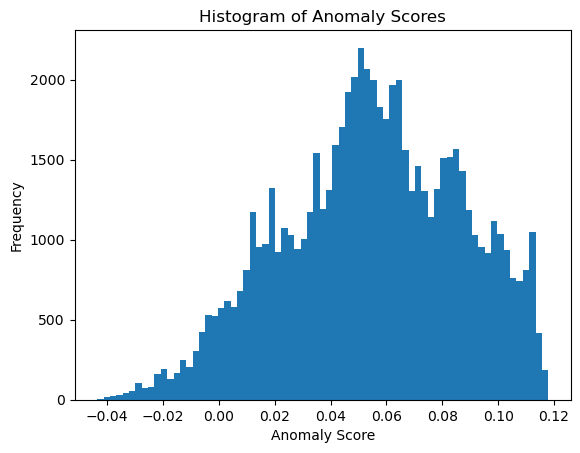

In [26]:
# Visualize anomaly scores
plt.hist(anomaly_scores, bins='auto')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Histogram of Anomaly Scores')
plt.show()


In [27]:
# Extract values from the 'is_anomaly' column
data = df.select('is_anomaly').rdd.flatMap(lambda x: x).collect()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(np.array(data).reshape(-1, 1))

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.2460
Epoch 2/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.2347
Epoch 3/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 0.2342
Epoch 4/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 0.2336
Epoch 5/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.2347
Epoch 6/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.2342
Epoch 7/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.2330
Epoch 8/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.2330
Epoch 9/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.2334
Epoch 10/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.2327
Epoch 11/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.2326
Epoch 12/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.2337
Epoch 13/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.2335
Epoch 14/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.2334

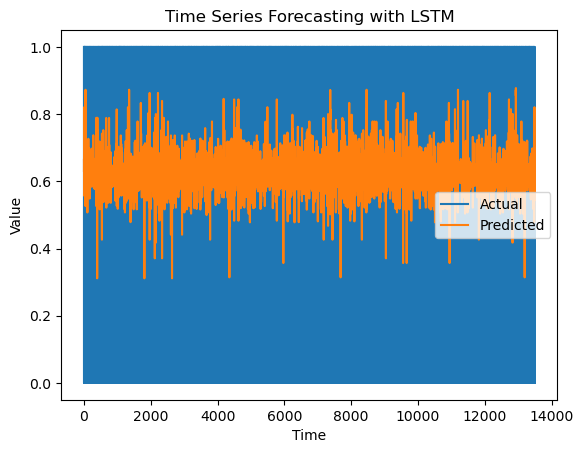

In [34]:
# Define window size for time series data
window_size = 10

# Function to create time series dataset
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Create time series dataset
X, y = create_dataset(data_normalized, window_size)

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(window_size, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MSE
train_mse = np.mean(np.square(y_train_inv - train_predictions))
test_mse = np.mean(np.square(y_test_inv - test_predictions))
print("Train MSE:", train_mse)
print("Test MSE:", test_mse)

# Plot predictions
plt.plot(y_test_inv, label='Actual')
plt.plot(test_predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Forecasting with LSTM')
plt.legend()
plt.show()

+------------------+-------------------+-----------+--------+---------------------------------------------+----------+-----------------+---------------+--------------+--------------+---------------------------+------------------------------+-----------------------------+----------+
|EventType         |Timestamp          |Location   |Severity|Details                                      |month_name|Timestamp_numeric|EventType_index|Location_index|Severity_index|features                   |rawPrediction                 |probability                  |prediction|
+------------------+-------------------+-----------+--------+---------------------------------------------+----------+-----------------+---------------+--------------+--------------+---------------------------+------------------------------+-----------------------------+----------+
|emergency_incident|2024-05-01 02:16:08|New York   |high    |This is a simulated emergency_incident event.|May       |1714529768       |0.0            

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


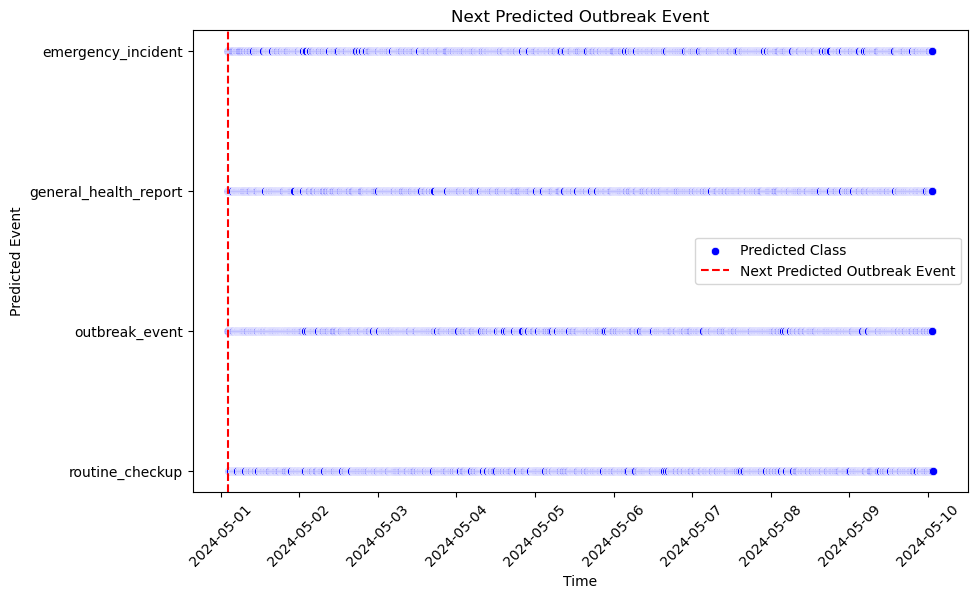

In [31]:
#Ensure predictions DataFrame is available
predictions.show(truncate=False)

#Replace 'outbreak_class_index' with the index corresponding to the outbreak event class
outbreak_class_index = 1  # Adjust based on your dataset specifics

#Identify the next predicted outbreak event
next_outbreak_event = predictions.filter(predictions['prediction'] == outbreak_class_index) \
                                 .orderBy('Timestamp_numeric') \
                                 .limit(1) \
                                 .toPandas()

#Convert the predictions DataFrame to a pandas DataFrame for visualization
predictions_pd = predictions.select(['Timestamp_numeric', 'prediction']).toPandas()

#Convert timestamps to readable dates
predictions_pd['Timestamp'] = pd.to_datetime(predictions_pd['Timestamp_numeric'], unit='s')

#Map the prediction indices to actual event types
event_type_mapping = {0: 'emergency_incident', 1: 'outbreak_event', 2: 'routine_checkup', 3: 'general_health_report'}
predictions_pd['Predicted_Event'] = predictions_pd['prediction'].map(event_type_mapping)

#Plot the time series of predictions with categorical plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=predictions_pd, x='Timestamp', y='Predicted_Event', label='Predicted Class', color='blue', marker='o')

#Highlight the next predicted outbreak event
if not next_outbreak_event.empty:
    next_event_time = pd.to_datetime(next_outbreak_event['Timestamp_numeric'].values[0], unit='s')
    plt.axvline(next_event_time, color='red', linestyle='--', label='Next Predicted Outbreak Event')

plt.title('Next Predicted Outbreak Event')
plt.xlabel('Time')
plt.ylabel('Predicted Event')
plt.legend()
plt.xticks(rotation=45)
plt.show()
